In [1]:
import numpy as np
import sys
from gym.envs.toy_text import discrete

In [2]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

In [3]:
class WindyGridworldEnv(discrete.DiscreteEnv):
  def __init__(self):
    self.shape = (7,10)
    nS = self.shape[0]*self.shape[1]
    nA = 4
    #Winds locations
    winds = np.zeros(self.shape)
    winds[:,[3,4,5,8]]=1
    winds[:,[6,7]]=2
    self.goal = (3,7)
    #Calcualte transition probabiliites and rewards
    P = {}
    for s in range(nS):
      position = np.unravel_index(s,self.shape)
      #print(position)
      P[s] = {a:[] for a in range(nA)}
      P[s][UP] = self._calculate_transition_prob(position,
                                                 [-1,0],winds)
      P[s][RIGHT] = self._calculate_transition_prob(position,
                                                 [0,1],winds)
      P[s][DOWN] = self._calculate_transition_prob(position,[1,0],
                                                   winds)
      P[s][LEFT] = self._calculate_transition_prob(position,[0,-1],winds)
      #print(P)

    #Calculate initial state distribution
    #We start in state (3,0)
    isd = np.zeros(nS)
    isd[np.ravel_multi_index((3,0),self.shape)] = 1.0
    super(WindyGridworldEnv,self).__init__(nS,nA,P,isd)

  def _calculate_transition_prob(self,current,delta,winds):
    """
    Determine the outcome for an action.
    Transition Prob is always 1.0

    @param current: (row,col), current position on the grid
    @param delta: Changein position for transition
    @param winds: Wind effect
    @return: (1.0,new_state,reward,is_done)
    """
    new_position = np.array(current) + np.array(delta) + np.array([-1,0])*winds[tuple(current)]
    new_position = self._limit_coordinates(new_position).astype(int)
    new_state = np.ravel_multi_index(tuple(new_position),self.shape)
    is_done = tuple(new_position) == self.goal
    return [(1.0,new_state,-1.0,is_done)]

  def _limit_coordinates(self,coord):
    coord[0] = min(coord[0],self.shape[0] -1)
    coord[0] = max(coord[0],0)
    coord[1] = min(coord[1],self.shape[1]-1)
    coord[1] = max(coord[1],0)

    return coord

  def render(self):
    # x represents the agent's current position.
    # T is the foal tile
    # the remaining tiles are denoted as o
    outfile = sys.stdout
    for s in range(self.nS):
      position = np.unravel_index(s,self.shape)
      if self.s == s:
        output = 'x'
      elif position == self.goal:
        output = "T"
      else:
        output = "o"

      if position[1] == 0:
        output = output.lstrip()
      if position[1] == self.shape[1]-1:
        output = output.rstrip()
        output += "\n"
      outfile.write(output)

    outfile.write("\n")




In [4]:
#instantiate an object of windy gridworld
env = WindyGridworldEnv()

In [5]:
env.reset()
env.render()

oooooooooo
oooooooooo
oooooooooo
xooooooToo
oooooooooo
oooooooooo
oooooooooo



In [6]:
print(env.step(UP))
env.render()

(20, -1.0, False, {'prob': 1.0})
oooooooooo
oooooooooo
xooooooooo
oooooooToo
oooooooooo
oooooooooo
oooooooooo



In [7]:
print(env.step(UP))
print(env.step(UP))
print(env.step(RIGHT))
env.render()

(10, -1.0, False, {'prob': 1.0})
(0, -1.0, False, {'prob': 1.0})
(1, -1.0, False, {'prob': 1.0})
oxoooooooo
oooooooooo
oooooooooo
oooooooToo
oooooooooo
oooooooooo
oooooooooo



In [8]:
env.s = 43
env.render()
env.step(RIGHT)
env.render()

oooooooooo
oooooooooo
oooooooooo
oooooooToo
oooxoooooo
oooooooooo
oooooooooo

oooooooooo
oooooooooo
oooooooooo
ooooxooToo
oooooooooo
oooooooooo
oooooooooo



In [9]:
env.s = 48
env.render()
env.step(LEFT)
env.render()

oooooooooo
oooooooooo
oooooooooo
oooooooToo
ooooooooxo
oooooooooo
oooooooooo

oooooooooo
oooooooooo
oooooooooo
oooooooxoo
oooooooooo
oooooooooo
oooooooooo



In [10]:
env.s = 47
env.render()
env.step(LEFT)
env.render()

oooooooooo
oooooooooo
oooooooooo
oooooooToo
oooooooxoo
oooooooooo
oooooooooo

oooooooooo
oooooooooo
ooooooxooo
oooooooToo
oooooooooo
oooooooooo
oooooooooo



In [11]:
env.s = 48
env.render()
env.step(RIGHT)
env.render()

oooooooooo
oooooooooo
oooooooooo
oooooooToo
ooooooooxo
oooooooooo
oooooooooo

oooooooooo
oooooooooo
oooooooooo
oooooooTox
oooooooooo
oooooooooo
oooooooooo



**SARSA** : State-Action-Reward-State-Action



SARSA focuses on state-action values.

It updates the Q-function based on the following equation:

Q(s,a) = Q(s,a) + α (r + γ Q(s',a') - Q(s,a))


Here s' is the resulting state after taking tha action ,a, in state s;

r is the associated reward;

α is the learning rate 

and γ is the discount factor.



In [12]:
import torch

In [13]:
def gen_epsilon_greedy_policy(n_action,epsilon):
  def policy_function(state,Q):
    probs = torch.ones(n_action)*epsilon/n_action
    best_action = torch.argmax(Q[state]).item()
    probs[best_action] += 1.0 - epsilon
    action = torch.multinomial(probs,1).item()
    return action
  return policy_function

In [14]:
n_episode = 500
length_episode = [0]*n_episode
total_reward_episode = [0]*n_episode

In [15]:
from collections import defaultdict
def sarsa(env,gamma,n_episode,alpha):
  """
  Obtaion the optimal policy with on-policy SARSA algorithm
  @param env: OpenAI Gym environment
  @param gamma: discount factor
  @param n_episode: number of episodes
  @return : The optimal Q-function and the optimal policy
  """
  n_action = env.action_space.n
  Q = defaultdict(lambda: torch.zeros(n_action))
  for episode in range(n_episode):
    state = env.reset()
    is_done = False
    action = epsilon_greedy_policy(state,Q)
    while not is_done:
      next_state,reward, is_done, info = env.step(action)
      next_action = epsilon_greedy_policy(next_state,Q)

      
      td_delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
      Q[state][action] += alpha * td_delta
      length_episode[episode] += 1
      total_reward_episode[episode] += reward
      if is_done:
        break
      state = next_state
      action = next_action

  policy = {}
  for state,actions in Q.items():
    policy[state] = torch.argmax(actions).item()

  return Q,policy 

In [16]:
gamma = 1
alpha = 0.4
epsilon = 0.1

In [17]:
epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n,epsilon)

In [18]:
optimal_Q, optimal_policy = sarsa(env,gamma,n_episode,alpha)


In [19]:
print('The optimal policy: \n',optimal_policy)

The optimal policy: 
 {30: 1, 20: 1, 10: 1, 0: 1, 1: 3, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 19: 2, 29: 2, 18: 1, 12: 1, 11: 1, 21: 1, 13: 1, 22: 1, 23: 1, 31: 1, 32: 1, 39: 2, 28: 1, 33: 1, 41: 1, 40: 1, 14: 1, 42: 1, 24: 1, 49: 3, 38: 2, 43: 2, 51: 1, 50: 1, 52: 1, 61: 1, 60: 1, 62: 0, 53: 1, 17: 1, 59: 0, 48: 3, 34: 1, 63: 1, 15: 1, 44: 1, 54: 1, 25: 1, 27: 0, 16: 3, 69: 3, 58: 3, 37: 0, 35: 1, 68: 3, 45: 1, 47: 2, 26: 1, 57: 2, 36: 1}


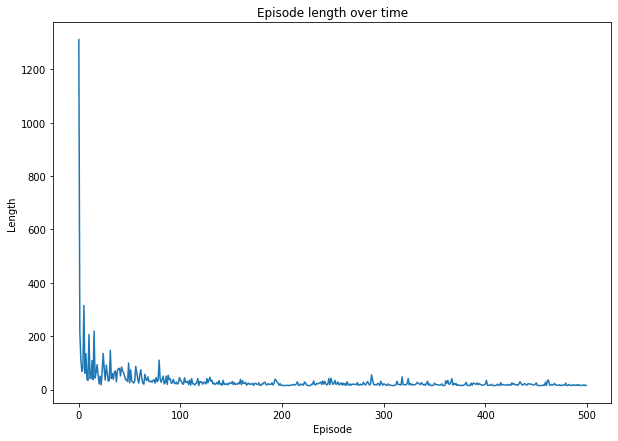

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()

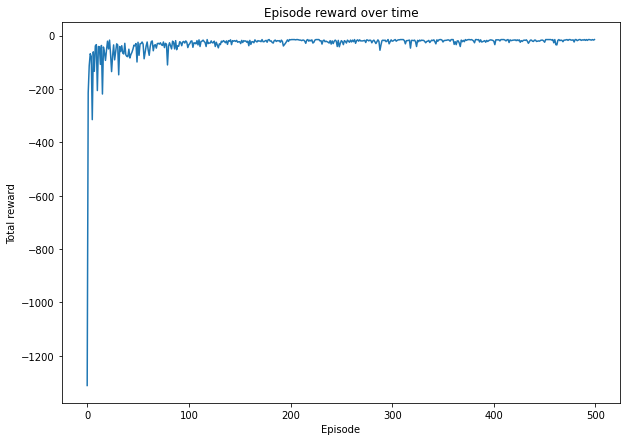

In [21]:
plt.figure(figsize=(10,7))
plt.plot(total_reward_episode)

plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [22]:
actions = {0:'UP',1:"RIGHT",2:"DOWN",3:"LEFT"}
print(actions[0])

UP


In [23]:
env.render()

oooooooooo
oooooooooo
oooooooooo
oooooooxoo
oooooooooo
oooooooooo
oooooooooo



In [24]:
env.goal


(3, 7)

In [25]:
#Following the optimal policy
state = env.reset()
print("I am here at {} my destination is {} but its windyworld ".format(state,env.goal[0]*10 + env.goal[1]))
env.render()

is_done = False
steps = 1
total_reward = 0

while not is_done:
  action = optimal_policy[state]
  print('I am going {}'.format(actions[action]))
  next_state,reward, is_done, info = env.step(action)
  print("I reached at {}".format(next_state))
  env.render()
  state = next_state
  steps += 1
  total_reward = total_reward + reward
  

  if(is_done):
    print('Reached the Destination safely in Windy World in {} steps with the reward of {}'.format(steps,total_reward))
    


I am here at 30 my destination is 37 but its windyworld 
oooooooooo
oooooooooo
oooooooooo
xooooooToo
oooooooooo
oooooooooo
oooooooooo

I am going RIGHT
I reached at 31
oooooooooo
oooooooooo
oooooooooo
oxoooooToo
oooooooooo
oooooooooo
oooooooooo

I am going RIGHT
I reached at 32
oooooooooo
oooooooooo
oooooooooo
ooxooooToo
oooooooooo
oooooooooo
oooooooooo

I am going RIGHT
I reached at 33
oooooooooo
oooooooooo
oooooooooo
oooxoooToo
oooooooooo
oooooooooo
oooooooooo

I am going RIGHT
I reached at 24
oooooooooo
oooooooooo
ooooxooooo
oooooooToo
oooooooooo
oooooooooo
oooooooooo

I am going RIGHT
I reached at 15
oooooooooo
oooooxoooo
oooooooooo
oooooooToo
oooooooooo
oooooooooo
oooooooooo

I am going RIGHT
I reached at 6
ooooooxooo
oooooooooo
oooooooooo
oooooooToo
oooooooooo
oooooooooo
oooooooooo

I am going RIGHT
I reached at 7
oooooooxoo
oooooooooo
oooooooooo
oooooooToo
oooooooooo
oooooooooo
oooooooooo

I am going RIGHT
I reached at 8
ooooooooxo
oooooooooo
oooooooooo
oooooooToo
oooooooooo
ooo